In [1]:
import gym
import random
import numpy as np
import pandas as pd
from datetime import timedelta
from timeit import default_timer as timer
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
id = 903657078

In [2]:
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(id)
sixteen = generate_random_map(16)
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "16x16": sixteen
}

In [3]:
def test_policy(env, policy, n_epoch=1000):
    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        while not done and ep < 10000:
            ep += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state
        rewards.append(episode_reward)
        episode_counts.append(ep)
    
    # all done
    mean_reward = sum(rewards)/len(rewards)
    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts 

In [4]:
def q_learning(env, discount=0.9, total_episodes=1e5, alpha=0.1, decay_rate=None,
               min_epsilon=0.01):
    
    start = timer()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    
    qtable = np.zeros((number_of_states, number_of_actions))
    learning_rate = alpha
    gamma = discount

    # exploration parameter
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    
    if not decay_rate:
        decay_rate = 1./total_episodes
    
    rewards = []
    for episode in range(int(total_episodes)):
        # reset the environment
        state = env.reset()
        step = 0
        done = False
        total_reward = 0
        while True:

            # choose an action a in the corrent world state
            exp_exp_tradeoff = random.uniform(0,1)

            # if greater than epsilon --> exploit
            if exp_exp_tradeoff > epsilon:
                b = qtable[state, :]
                action = np.random.choice(np.where(b == b.max())[0])
#                 action = np.argmax(qtable[state, :])
            # else choose exploration
            else:
                action = env.action_space.sample()

            # take action (a) and observe the outcome state (s') and reward (r)    
            new_state, reward, done, info = env.step(action)
            total_reward += reward
            # update Q(s,a) := Q(s,a) + lr [R(s,a) + gamma * max(Q (s', a') - Q(s,a))]
            if not done:
                qtable[state, action] = qtable[state, action] + learning_rate*(reward + gamma*np.max(qtable[new_state, :]) - qtable[state, action])
            else:
                qtable[state, action] = qtable[state,action] + learning_rate*(reward - qtable[state,action])

            # change state
            state = new_state

            # is it Done
            if done:
                break
                
        # reduce epsilon 
        rewards.append(total_reward)
        epsilon = max(max_epsilon -  decay_rate * episode, min_epsilon) 
    #     print (epsilon)
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(total_episodes, time_spent))
    return np.argmax(qtable, axis=1), total_episodes, time_spent, qtable, rewards

In [5]:
def train_and_test_q_learning(env, discount=[0.9], total_episodes=[1e5], alphas=[0.1], decay_rates=[0.01], mute=False):
    
    min_epsilon = 0.01
    
    q_dict = {}
    for dis in discount:
        q_dict[dis] = {}
        for eps in total_episodes:
            q_dict[dis][eps] = {}
            for alpha in alphas:
                q_dict[dis][eps][alpha] = {}
                for dr in decay_rates:
                    q_dict[dis][eps][alpha][dr] = {}
                    
                    # run q_learning
                    q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning(env, dis, eps, alpha, dr, min_epsilon)
                    q_mrews, q_meps, _, __ = test_policy(env, q_policy)
                    q_dict[dis][eps][alpha][dr]["mean_reward"] = q_mrews
                    q_dict[dis][eps][alpha][dr]["mean_eps"] = q_meps
                    q_dict[dis][eps][alpha][dr]["q-table"] = q_table
                    q_dict[dis][eps][alpha][dr]["rewards"] = rewards 
                    q_dict[dis][eps][alpha][dr]["iteration"] = q_solve_iter
                    q_dict[dis][eps][alpha][dr]["time_spent"] = q_solve_time
                    q_dict[dis][eps][alpha][dr]["policy"] = q_policy
                    if not mute:
                        print("gamma: {} total_eps: {} lr: {}, dr: {}".format(dis, eps, alpha, dr))
                        print("Iteration: {} time: {}".format(q_solve_iter, q_solve_time))
                        print("Mean reward: {} - mean eps: {}".format(q_mrews, q_meps))
    return q_dict

In [6]:
def map_discretize(the_map):
    size = len(the_map)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(the_map):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map


def policy_numpy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def see_policy(map_size, policy):
    map_name = str(map_size)+"x"+str(map_size)
    data = map_discretize(MAPS[map_name])
    np_pol = policy_numpy(policy)
    plt.imshow(data, interpolation="nearest", cmap='ocean')

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="r")
    plt.show()

In [7]:
def dict_to_df(the_dict):
    the_df = pd.DataFrame(columns=["Discount Rate", "Training Iterations", "Learning Rate", 
                                   "Decay Rate", "Reward", "Time Spent"])
    for dis in the_dict:
        for eps in the_dict[dis]:
            for lr in the_dict[dis][eps]:
                for dr in the_dict[dis][eps][lr]:
                    rew = the_dict[dis][eps][lr][dr]["mean_reward"]
                    time_spent = the_dict[dis][eps][lr][dr]["time_spent"].total_seconds()
                    dic = {"Discount Rate": dis, "Training Iterations": eps, "Learning Rate":lr, 
                           "Decay Rate":dr, "Reward": rew, "Time Spent": time_spent}
                    the_df = the_df.append(dic, ignore_index=True)
    return the_df

In [8]:
import numpy as np
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [9]:
env = gym.make('FrozenLake-v1')
episodes = [1e4, 1e5, 1e6]
decays = [1e-6]

q_dict = train_and_test_q_learning(env, discount=[0.5, 0.7, 0.9, 0.99], total_episodes=episodes,
                          alphas=[0.01, 0.1], decay_rates=decays)

Solved in: 10000.0 episodes and 0:00:01.367948 seconds
gamma: 0.5 total_eps: 10000.0 lr: 0.01, dr: 1e-06
Iteration: 10000.0 time: 0:00:01.367948
Mean reward: 0.088 - mean eps: 8.042
Solved in: 10000.0 episodes and 0:00:01.391965 seconds
gamma: 0.5 total_eps: 10000.0 lr: 0.1, dr: 1e-06
Iteration: 10000.0 time: 0:00:01.391965
Mean reward: 0.077 - mean eps: 12.419
Solved in: 100000.0 episodes and 0:00:14.009898 seconds
gamma: 0.5 total_eps: 100000.0 lr: 0.01, dr: 1e-06
Iteration: 100000.0 time: 0:00:14.009898
Mean reward: 0.458 - mean eps: 27.496
Solved in: 100000.0 episodes and 0:00:13.689072 seconds
gamma: 0.5 total_eps: 100000.0 lr: 0.1, dr: 1e-06
Iteration: 100000.0 time: 0:00:13.689072
Mean reward: 0.098 - mean eps: 9.757
Solved in: 1000000.0 episodes and 0:03:31.204478 seconds
gamma: 0.5 total_eps: 1000000.0 lr: 0.01, dr: 1e-06
Iteration: 1000000.0 time: 0:03:31.204478
Mean reward: 0.507 - mean eps: 31.331
Solved in: 1000000.0 episodes and 0:02:57.378062 seconds
gamma: 0.5 total_eps

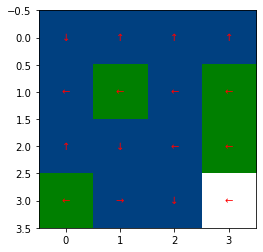

In [10]:
pol = q_dict[0.99][int(1e6)][0.1][1e-06]['policy']
see_policy(4, pol)

In [11]:
episodes = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]
q_dict = train_and_test_q_learning(env, discount= [0.99], total_episodes=episodes,
                          alphas=[0.1, 0.01], decay_rates=decays)

Solved in: 10000.0 episodes and 0:00:08.892006 seconds
gamma: 0.99 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 0:00:08.892006
Mean reward: 0.718 - mean eps: 41.16
Solved in: 10000.0 episodes and 0:00:01.475266 seconds
gamma: 0.99 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 0:00:01.475266
Mean reward: 0.727 - mean eps: 40.735
Solved in: 10000.0 episodes and 0:00:02.368144 seconds
gamma: 0.99 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 0:00:02.368144
Mean reward: 0.097 - mean eps: 9.834
Solved in: 10000.0 episodes and 0:00:01.446217 seconds
gamma: 0.99 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 0:00:01.446217
Mean reward: 0.514 - mean eps: 33.937
Solved in: 100000.0 episodes and 0:01:33.462605 seconds
gamma: 0.99 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 0:01:33.462605
Mean reward: 0.751 - mean eps: 41.513
Solved in: 100000.0 episodes and 0:00:38.057030 seconds
gamma: 0.99 total_eps: 100

D:\App\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

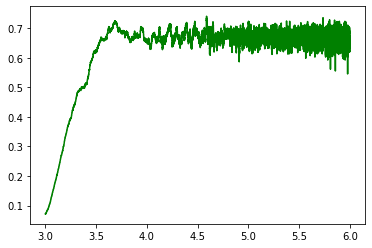

In [12]:
rews = q_dict[0.99][int(1e6)][0.1][1e-03]['rewards']
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.lineplot(np.log10(indices), rew_running, color='g')

D:\App\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

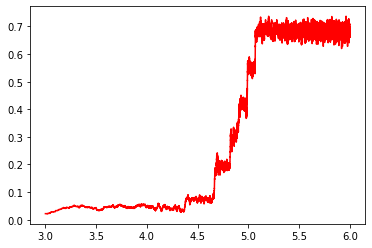

In [13]:
rews = q_dict[0.99][int(1e6)][0.01][1e-03]['rewards']
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.lineplot(np.log10(indices), rew_running, color='r')

D:\App\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

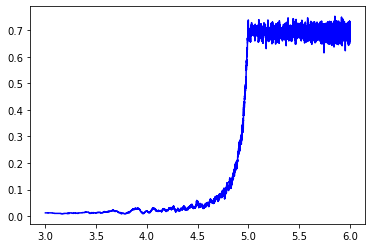

In [14]:
rews = q_dict[0.99][int(1e6)][0.01][1e-05]['rewards']
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.lineplot(np.log10(indices), rew_running, color='b')

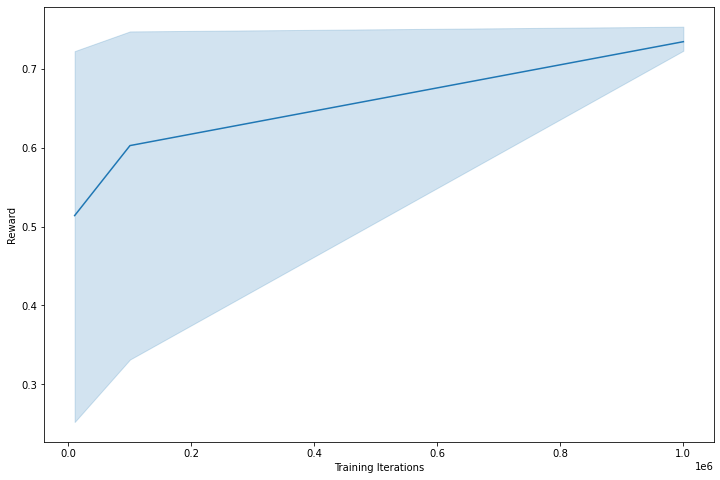

In [15]:
q4 = dict_to_df(q_dict)
# plt.figure(figsize=(12, 8))
pl = sns.lineplot(x="Training Iterations", y="Reward", data=q4)
pl.figure.set_figwidth(12)
pl.figure.set_figheight(8)

In [16]:
q4

,Discount Rate,Training Iterations,Learning Rate,Decay Rate,Reward,Time Spent
0,0.99,10000.0,0.10,0.00100,0.718,8.892006
1,0.99,10000.0,0.10,0.00001,0.727,1.475266
2,0.99,10000.0,0.01,0.00100,0.097,2.368144
3,0.99,10000.0,0.01,0.00001,0.514,1.446217
4,0.99,100000.0,0.10,0.00100,0.751,93.462605
5,0.99,100000.0,0.10,0.00001,0.722,38.057030
6,0.99,100000.0,0.01,0.00100,0.194,52.052706
7,0.99,100000.0,0.01,0.00001,0.744,37.220187
8,0.99,1000000.0,0.10,0.00100,0.724,1018.578890
9,0.99,1000000.0,0.10,0.00001,0.761,957.502382


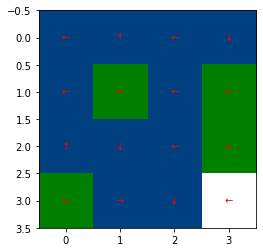

In [17]:
pol = q_dict[0.99][int(1e6)][0.01][1e-03]['policy']
see_policy(4, pol)

## 16x16

In [18]:
env = FrozenLakeEnv(desc=MAPS["16x16"])
episodes = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]
q_dict16 = train_and_test_q_learning(env, discount= [0.99], total_episodes=episodes,
                          alphas=[0.1, 0.01], decay_rates=decays)

Solved in: 10000.0 episodes and 0:00:03.672990 seconds
gamma: 0.99 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 0:00:03.672990
Mean reward: 0.0 - mean eps: 29.575
Solved in: 10000.0 episodes and 0:00:02.737523 seconds
gamma: 0.99 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 0:00:02.737523
Mean reward: 0.0 - mean eps: 29.391
Solved in: 10000.0 episodes and 0:00:03.814399 seconds
gamma: 0.99 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 0:00:03.814399
Mean reward: 0.0 - mean eps: 31.758
Solved in: 10000.0 episodes and 0:00:02.761805 seconds
gamma: 0.99 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 0:00:02.761805
Mean reward: 0.0 - mean eps: 29.435
Solved in: 100000.0 episodes and 0:00:38.256515 seconds
gamma: 0.99 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 0:00:38.256515
Mean reward: 0.0 - mean eps: 29.757
Solved in: 100000.0 episodes and 0:00:32.938152 seconds
gamma: 0.99 total_eps: 100000.0 lr

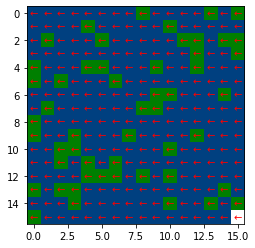

In [19]:
pol = q_dict16[0.99][int(1e6)][0.1][1e-05]['policy']
see_policy(16, pol)

In [20]:
(q_dict16[0.99][int(1e6)][0.1][1e-05]['q-table'] > 0).any()

False

D:\App\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

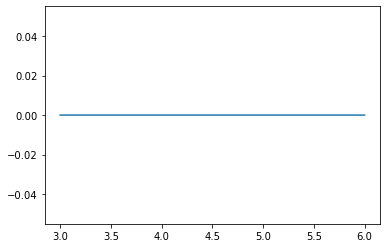

In [21]:
rews = q_dict16[0.99][int(1e6)][0.1][1e-05]['rewards']
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.lineplot(np.log10(indices), rew_running)

In [22]:
q16 = dict_to_df(q_dict16)
q16

,Discount Rate,Training Iterations,Learning Rate,Decay Rate,Reward,Time Spent
0,0.99,10000.0,0.10,0.00100,0.0,3.672990
1,0.99,10000.0,0.10,0.00001,0.0,2.737523
2,0.99,10000.0,0.01,0.00100,0.0,3.814399
3,0.99,10000.0,0.01,0.00001,0.0,2.761805
4,0.99,100000.0,0.10,0.00100,0.0,38.256515
5,0.99,100000.0,0.10,0.00001,0.0,32.938152
6,0.99,100000.0,0.01,0.00100,0.0,38.845153
7,0.99,100000.0,0.01,0.00001,0.0,33.337852
8,0.99,1000000.0,0.10,0.00100,0.0,386.191705
9,0.99,1000000.0,0.10,0.00001,0.0,380.402202
